<a href="https://colab.research.google.com/github/ioanabirlan/wids-datathon-university-solution1/blob/main/Route2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Title & Team Info

**Project Title**: _Workshop 1: WiDS University Datathon 2026_  
**Team Name**: _Research DUO_  
**University**: _Bucharest University of Economic Studies_  
**Course**: _Software Open Source for Statistics and Data Science_  
**Term**: _1st Semester, 2025_  

**Team Members**:  
- Gianina Petrașcu (GitHub: [@gianinapetrascu](https://github.com/gianinapetrascu))  
- Ioana Bîrlan (GitHub: [@ioanabirlan](https://github.com/ioanabirlan))  


### 🔹 Route 2: Designing for Economic Resilience

**Core Question:**  
*How can wildfire disruption analytics inform stronger economic safety nets for affected workers, families, and small businesses?*

This route is about quantifying how wildfires affect employment, income, and tourism — and using that insight to design better protections for vulnerable communities.

## Dataset Overview

Summarize the datasets you used and how you processed them.

- `infrastructure.csv`: Metadata and coordinates of infrastructure
- `fire_perimeters.geojson`: Timestamped fire perimeter polygons
- `evacuation_zones.csv`: (Optional) evacuation declarations
- `watch_duty_change_log.csv`: Alerts and timestamps
- US census data

**Load data**

Kaggle data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gianinamariapetrascu","key":"3b4740567442e05ace027246b5e7d29a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c wids-university-datathon-2025


 92% 372M/403M [00:02<00:00, 65.9MB/s]
100% 403M/403M [00:02<00:00, 145MB/s] 


In [ ]:
!unzip wids-university-datathon-2025.zip -d data/

Archive:  wids-university-datathon-2025.zip
  inflating: data/WiDS _-_ Watch Duty_ Data Dictionary.docx  
  inflating: data/evac_zone_status_geo_event_map.csv  
  inflating: data/evac_zones_gis_evaczone.csv  
  inflating: data/evac_zones_gis_evaczonechangelog.csv  
  inflating: data/fire_perimeters_gis_fireperimeter.csv  
  inflating: data/fire_perimeters_gis_fireperimeterchangelog.csv  
  inflating: data/geo_events_externalgeoevent.csv  
  inflating: data/geo_events_externalgeoeventchangelog.csv  
  inflating: data/geo_events_geoevent.csv  
  inflating: data/geo_events_geoeventchangelog.csv  


External Census Data

In [ ]:
!ls *.zip

ACSDP5Y2023.DP03_2025-11-04T014551.zip
ACSDT5Y2023.B01003_2025-11-04T014346.zip
ACSDT5Y2023.B19013_2025-11-04T014131.zip
ACSST5Y2023.S1701_2025-11-04T014746.zip
wids-university-datathon-2025.zip


In [ ]:
import zipfile, glob, os
from pathlib import Path

Path("external_data").mkdir(exist_ok=True)

# Extract ACS datasets
acs_zips = glob.glob("ACS*.zip")
for z in acs_zips:
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall("external_data")

!ls external_data

ACSDP5Y2023.DP03-Column-Metadata.csv	ACSDT5Y2023.B19013-Data.csv
ACSDP5Y2023.DP03-Data.csv		ACSDT5Y2023.B19013-Table-Notes.txt
ACSDP5Y2023.DP03-Table-Notes.txt	acs_income_employment.csv
ACSDT5Y2023.B01003-Column-Metadata.csv	ACSST5Y2023.S1701-Column-Metadata.csv
ACSDT5Y2023.B01003-Data.csv		ACSST5Y2023.S1701-Data.csv
ACSDT5Y2023.B01003-Table-Notes.txt	ACSST5Y2023.S1701-Table-Notes.txt
ACSDT5Y2023.B19013-Column-Metadata.csv


Merge Census data

In [ ]:
import pandas as pd, re, glob

# Find all the ACS *-Data.csv files
csvs = [f for f in glob.glob("external_data/*-Data.csv")]
print("Found ACS CSVs:", csvs)

def read_acs(pattern, value_col, rename_to):
    path = next((f for f in csvs if pattern in f), None)
    if not path:
        raise FileNotFoundError(f"No ACS file matching {pattern}")
    df = pd.read_csv(path)
    geo_col = next((c for c in df.columns if re.search("GEO", c, re.I)), None)
    df["county_fips"] = df[geo_col].astype(str).str.extract(r'(\d{5})$')
    df = df.rename(columns={value_col: rename_to})
    return df[["county_fips", rename_to]]

income = read_acs("B19013", "B19013_001E", "median_income")
pop    = read_acs("B01003", "B01003_001E", "population")
unemp  = read_acs("DP03", "DP03_0005PE", "unemployment_rate")
pov    = read_acs("S1701", "S1701_C02_001E", "poverty_rate")

# Merge them
acs = income.merge(pop, on="county_fips", how="outer") \
            .merge(unemp, on="county_fips", how="outer") \
            .merge(pov, on="county_fips", how="outer")

for col in ["median_income", "unemployment_rate", "poverty_rate", "population"]:
    acs[col] = pd.to_numeric(acs[col], errors="coerce")

acs.dropna(subset=["county_fips"], inplace=True)
acs["county_fips"] = acs["county_fips"].astype(str).str.zfill(5)

acs.to_csv("external_data/acs_income_employment.csv", index=False)
print("Clean ACS dataset saved:", acs.shape)
acs.head()


Found ACS CSVs: ['external_data/ACSDP5Y2023.DP03-Data.csv', 'external_data/ACSDT5Y2023.B19013-Data.csv', 'external_data/ACSST5Y2023.S1701-Data.csv', 'external_data/ACSDT5Y2023.B01003-Data.csv']


/tmp/ipython-input-4194641492.py:11: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,144,145,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,276,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,296,297,298,299,300,301,302,304,305,306,308,309,310,312,

Clean ACS dataset saved: (3222, 5)


/tmp/ipython-input-4194641492.py:11: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,242,243,244,245,246,247,248,249,250,251,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,292,293,294,295,296,297,298,299,302,303,304,305,306,307,308,30

,county_fips,median_income,population,unemployment_rate,poverty_rate
0,01001,69841.0,59285.0,1.4,6275.0
1,01003,75019.0,239945.0,1.9,24819.0
2,01005,44290.0,24757.0,2.6,4746.0
3,01007,51215.0,22152.0,5.1,4258.0
4,01009,61096.0,59292.0,3.3,8269.0


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
from shapely.geometry import Point

In [ ]:
events    = pd.read_csv("data/geo_events_geoevent.csv", low_memory=True)

In [ ]:
events.head()

,id,date_created,date_modified,geo_event_type,name,is_active,description,address,lat,lng,data,notification_type,external_id,external_source,incident_id,reporter_managed,is_visible
0,76,2021-08-11 00:09:56.481066,2023-02-09 20:34:24.180117,wildfire,Todd Fire,0,NaN,"Llano Rd & Todd Rd, Santa Rosa, California 95...",38.386100,-122.769299,"{""is_fps"": false, ""acreage"": 50, ""containment""...",normal,1008375748,pulsepoint,76.0,1,0
1,77,2021-08-11 07:21:46.054995,2023-02-09 20:34:24.225186,wildfire,Vegetation Fire,0,NaN,"Guerneville Rd & W Steele Ln, Santa Rosa, CA 9...",38.459967,-122.728927,"{""is_fps"": false, ""acreage"": 0, ""containment"":...",normal,1008583077,pulsepoint,77.0,1,0
2,78,2021-08-11 21:02:16.301416,2023-02-09 20:34:24.266124,wildfire,Ford Fire,0,NaN,"CA-1 & Valley Ford Estero Rd, Valley Ford, CA ...",38.318328,-122.925698,"{""is_fps"": false, ""acreage"": 0, ""containment"":...",normal,1008957703,pulsepoint,78.0,1,0
3,79,2021-08-12 01:46:31.043052,2023-02-09 20:34:24.308048,wildfire,Vegetation Fire,0,NaN,"19428 Redwood Dr, Monte Rio, CA 95462, USA",38.479988,-122.994156,"{""is_fps"": false, ""acreage"": 0, ""containment"":...",normal,1009152928,pulsepoint,79.0,1,0
4,80,2021-08-12 02:40:30.939331,2023-02-09 20:34:24.358582,wildfire,Shoreline Fire,0,NaN,"Shoreline Dr, Napa, CA 94558, USA",38.315222,-122.276532,"{""is_fps"": false, ""acreage"": 0, ""containment"":...",normal,1009187142,pulsepoint,80.0,1,0


## Approach

In [ ]:
# keep wildfires only
events = events[events["geo_event_type"] == "wildfire"].copy()

# basic cleaning
events = events[["id", "name", "lat", "lng", "date_created", "date_modified", "is_active", "data"]]
events.dropna(subset=["lat","lng"], inplace=True)

# extract containment and acreage from JSON-encoded data
def extract_json_field(js, key):
    if not isinstance(js, str) or "{" not in js: return np.nan
    try:
        parsed = json.loads(js.strip().strip('"').strip("'"))
        return parsed.get(key, np.nan)
    except Exception:
        return np.nan

for col in ["is_prescribed","is_fps","containment","acreage"]:
    events[col] = events["data"].apply(lambda x: extract_json_field(x, col))

events.drop(columns=["data"], inplace=True, errors="ignore")
events.head()

,id,name,lat,lng,date_created,date_modified,is_active,is_prescribed,is_fps,containment,acreage
0,76,Todd Fire,38.386100,-122.769299,2021-08-11 00:09:56.481066,2023-02-09 20:34:24.180117,0,False,False,100.0,50.0
1,77,Vegetation Fire,38.459967,-122.728927,2021-08-11 07:21:46.054995,2023-02-09 20:34:24.225186,0,False,False,100.0,0.0
2,78,Ford Fire,38.318328,-122.925698,2021-08-11 21:02:16.301416,2023-02-09 20:34:24.266124,0,False,False,0.0,0.0
3,79,Vegetation Fire,38.479988,-122.994156,2021-08-12 01:46:31.043052,2023-02-09 20:34:24.308048,0,False,False,0.0,0.0
4,80,Shoreline Fire,38.315222,-122.276532,2021-08-12 02:40:30.939331,2023-02-09 20:34:24.358582,0,False,False,100.0,0.0


Preview shows cleaned wildfire events with key metadata:
- Each row = one wildfire incident with location (lat/lng), timestamps, and extracted attributes.
- Dataset is ready for spatial or temporal merging with census and alert data.

US county shapefile

In [ ]:
!mkdir -p shapefiles
!wget -q https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip -O shapefiles/us_counties.zip
!unzip -q shapefiles/us_counties.zip -d shapefiles/

In [ ]:
# load shapefile
counties = gpd.read_file("shapefiles/tl_2023_us_county.shp")[["STATEFP", "COUNTYFP", "NAME", "geometry"]]
counties["county_fips"] = (counties["STATEFP"] + counties["COUNTYFP"]).astype(str)

# turn events into GeoDataFrame
gdf = gpd.GeoDataFrame(
    events,
    geometry=[Point(xy) for xy in zip(events.lng, events.lat)],
    crs="EPSG:4326"
)

# spatial join
gdf_joined = gpd.sjoin(gdf, counties, how="left", predicate="within")
gdf_joined["county_fips"] = gdf_joined["county_fips"].astype(str).str.zfill(5)
print("Mapped fires to counties:", gdf_joined.shape)
gdf_joined[["id", "name", "county_fips", "containment", "acreage"]].head()

/tmp/ipython-input-1430814938.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  gdf_joined = gpd.sjoin(gdf, counties, how="left", predicate="within")


Mapped fires to counties: (61779, 17)


,id,name,county_fips,containment,acreage
0,76,Todd Fire,06097,100.0,50.0
1,77,Vegetation Fire,06097,100.0,0.0
2,78,Ford Fire,06097,0.0,0.0
3,79,Vegetation Fire,06097,0.0,0.0
4,80,Shoreline Fire,06055,100.0,0.0


Spatial join summary:
- Each wildfire point was matched to a county polygon using `within`.


In [ ]:
gdf_joined["county_fips"] = (
    gdf_joined["county_fips"].astype(str).str.extract(r"(\d{5})")[0].str.zfill(5))
acs["county_fips"] = acs["county_fips"].astype(str).str.zfill(5)

merged = gdf_joined.merge(acs, on="county_fips", how="left")

print("Merged successfully:", merged.shape)
merged[["id","name","county_fips","median_income","unemployment_rate","poverty_rate","population"]].head()


Merged successfully: (61779, 21)


,id,name,county_fips,median_income,unemployment_rate,poverty_rate,population
0,76,Todd Fire,06097,102840.0,3.3,41044.0,485642.0
1,77,Vegetation Fire,06097,102840.0,3.3,41044.0,485642.0
2,78,Ford Fire,06097,102840.0,3.3,41044.0,485642.0
3,79,Vegetation Fire,06097,102840.0,3.3,41044.0,485642.0
4,80,Shoreline Fire,06055,108970.0,3.2,11238.0,136070.0


Analyze correlations

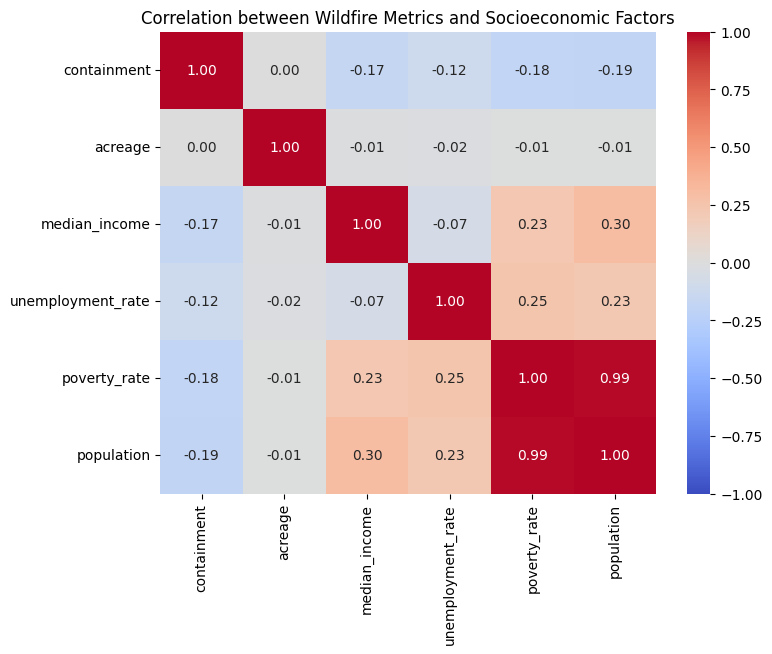

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# correlation of fire impact with socioeconomic variables
cols = ["containment","acreage","median_income","unemployment_rate","poverty_rate","population"]
corr = merged[cols].apply(pd.to_numeric, errors="coerce").corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation between Wildfire Metrics and Socioeconomic Factors")
plt.show()

Wildfire metrics show weak correlations with socioeconomic factors:
- Containment slightly lower in poorer, less affluent counties
- Acreage is mostly uncorrelated with income or population.  
- Median income, poverty, and unemployment are moderately correlated

Overall  socioeconomic context has limited direct correlation with wildfire size or containment, suggesting other structural or geographic factors drive response differences.

Economic exposure by county

In [ ]:
impact = (
    merged.groupby("county_fips")
    .agg(
        fires=("id","count"),
        total_acres=("acreage","sum"),
        avg_containment=("containment","mean"),
        median_income=("median_income","mean"),
        unemployment=("unemployment_rate","mean"),
        poverty=("poverty_rate","mean"),
        population=("population","mean")).reset_index())

impact["acres_per_1000_people"] = impact["total_acres"] / (impact["population"]/1000)
impact["fire_risk_index"] = (
    impact["acres_per_1000_people"] * (1 + impact["poverty"]/100 - impact["median_income"]/1e5))

impact.head()


,county_fips,fires,total_acres,avg_containment,median_income,unemployment,poverty,population,acres_per_1000_people,fire_risk_index
0,04001,465,69984.400,96.897638,40338.0,4.1,20070.0,65680.0,1065.535932,214488.781558
1,04003,401,26616.290,93.759036,58970.0,3.3,18544.0,125458.0,212.152991,39428.697105
2,04005,1331,455420.865,95.074627,69748.0,4.1,23485.0,144643.0,3148.585587,740397.835120
3,04007,553,121725.720,95.537906,59089.0,3.4,9297.0,53610.0,2270.578623,212024.611037
4,04009,301,57135.890,95.105960,67326.0,3.2,6319.0,38860.0,1470.300823,93388.715126


The code groups wildfire and census data by county to summarize impacts.
It calculates total fires, acres burned, average containment, and local income, poverty, and unemployment.
Then it adds two new metrics:
- acres_per_1000_people - fire exposure relative to population
- fire_risk_index - combines fire exposure with poverty and income

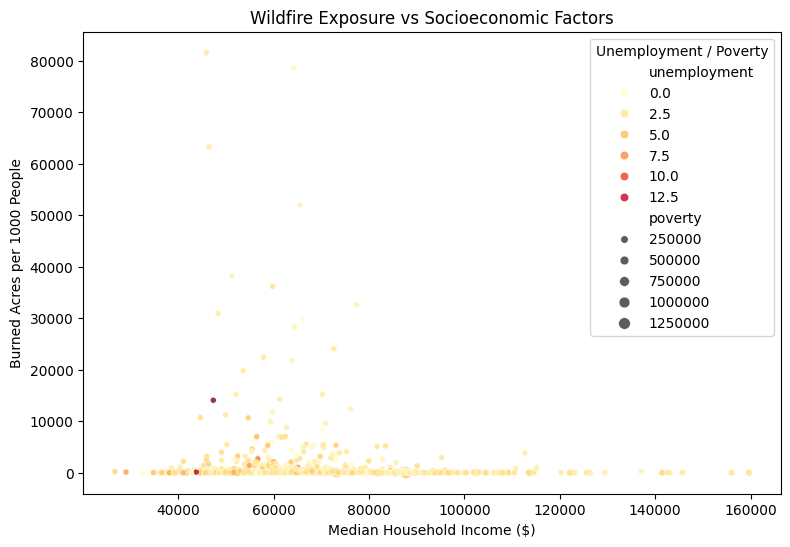

In [ ]:
plt.figure(figsize=(9,6))
sns.scatterplot(
    data=impact,
    x="median_income", y="acres_per_1000_people",
    size="poverty", hue="unemployment",
    palette="YlOrRd", alpha=0.8
)
plt.title("Wildfire Exposure vs Socioeconomic Factors")
plt.xlabel("Median Household Income ($)")
plt.ylabel("Burned Acres per 1000 People")
plt.legend(title="Unemployment / Poverty")
plt.show()


The chart shows how wildfire exposure (burned acres per 1,000 people) relates to county income, poverty, and unemployment:
- Most high-income areas have lower exposure.
- A few low- to mid-income counties show very high exposure.
- Darker/red points (higher unemployment) cluster in lower-income areas.

In [ ]:
import folium
from folium import Choropleth

if "GEOID" not in counties.columns:
    counties["GEOID"] = (counties["STATEFP"] + counties["COUNTYFP"]).astype(str)

# interactive Choropleth map
m = folium.Map(location=[37.5, -119], zoom_start=5, tiles="cartodbpositron")

Choropleth(
    geo_data=counties,
    data=impact,
    columns=["county_fips", "fire_risk_index"],
    key_on="feature.properties.GEOID",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Fire Risk Index (weighted by poverty & income)").add_to(m)

m.save("route2_fire_econ_map.html")
m


  ML models

In [ ]:
!pip install lightgbm shap -q

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
# relevant features and target variable
features = ["fires", "total_acres", "avg_containment", "unemployment", "poverty", "median_income"]
target = "fire_risk_index"

df = impact.dropna(subset=features + [target]).copy()
X = df[features]
y = df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Train a baseline LightGBM
lgbm = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm.fit(X_train_scaled, y_train)

# baseline performance
y_pred = lgbm.predict(X_test_scaled)
print("LightGBM Baseline Performance")
print("R²:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 628, number of used features: 6
[LightGBM] [Info] Start training from score 22059.233693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM baseline (county-level fire risk):
- R² = 0.496 - model explains ~50% of variance in fire_risk_index.
- MAE ≈ 19.2k - average prediction error.

- Features have real predictive signal, but plenty of unexplained variation remains.
- Try adding interaction/geographic features (e.g., region dummies, elevation/forest cover),
  tuning num_leaves/learning_rate, and evaluating with SHAP to see which inputs drive risk.

In [ ]:
# grid of parameters to tune
param_grid = {
    "num_leaves": [15, 30],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [500, 1000],
    "subsample": [0.7, 0.9]
}

# Grid search
grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=3,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

print("Best Model Parameters:")
print(grid.best_params_)
print("R^2:", round(r2_score(y_test, y_pred_best), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred_best), 2))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 628, number of used features: 6
[LightGBM] [Info] Start training from score 22059.233693
Best Model Parameters:
{'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 15, 'subsample': 0.7}
R^2: 0.526
MAE: 14714.71


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM tuning improved performance:
- Best params: num_leaves=15, learning_rate=0.01, n_estimators=500, subsample=0.7
- R squared increased from 0.50 > 0.53; MAE decreased from 19.2k to 14.7k

Takeaway: tuning helps, but more signal likely from richer features (regional dummies, land cover, climate) and SHAP checks.


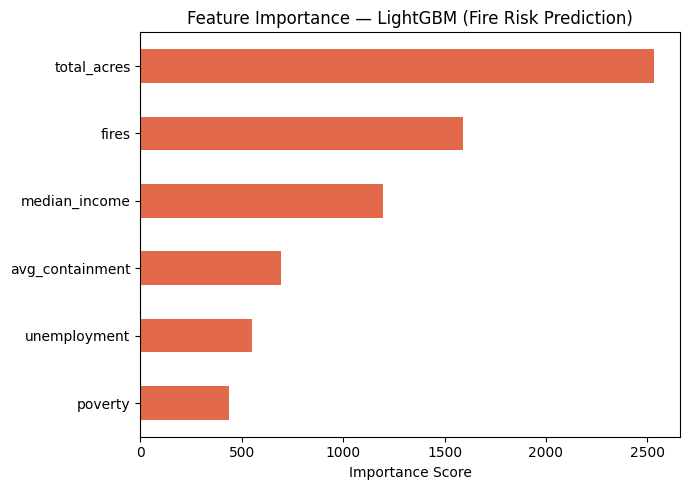

In [ ]:
# feature importance scores
importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(7,5))
importances.plot(kind="barh", color="#E26A4A")
plt.title("Feature Importance — LightGBM (Fire Risk Prediction)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Feature importance:
- total_acres - strongest predictor of county fire risk
- fires and median_income also contribute notably
- containment, unemployment, and poverty have smaller but nontrivial effects

Interpretation:
Areas with larger burned acreage and more frequent fires show higher predicted risk, while lower median income mildly increases vulnerability.

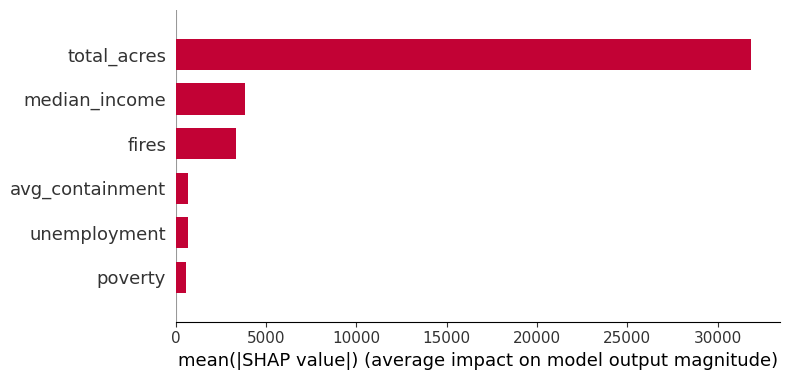

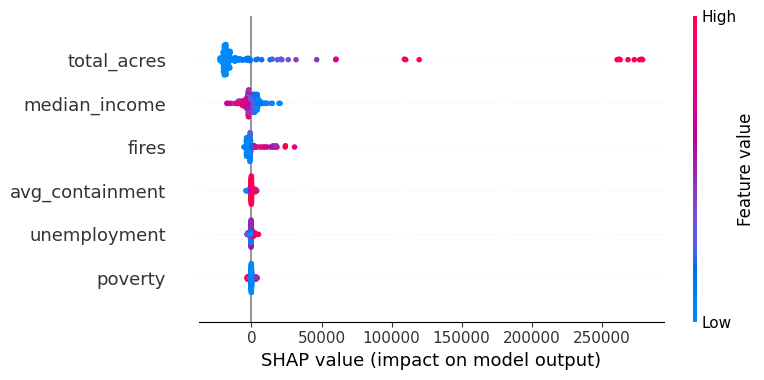

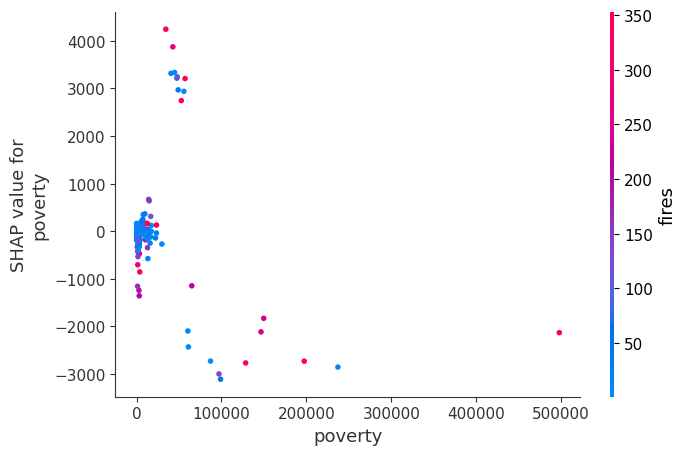

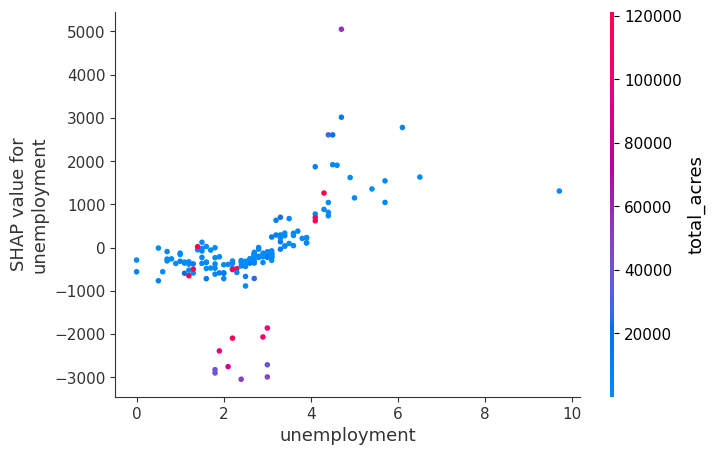

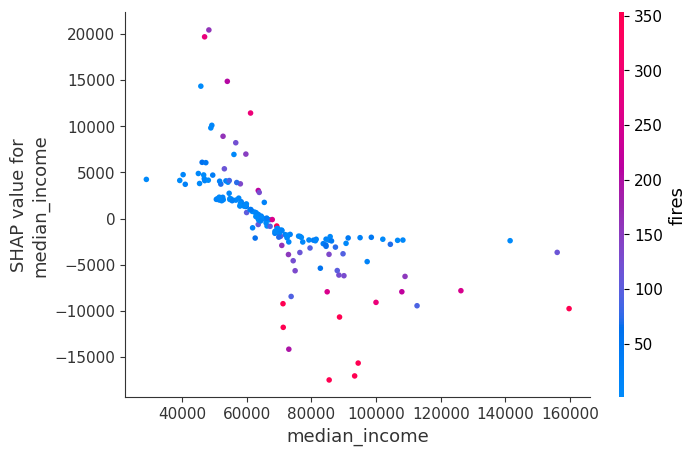

In [ ]:
# SHAP analysis
shap.initjs()

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test, plot_type="bar", color="#c20235")
shap.summary_plot(shap_values, X_test, color="#c20235")

for col in ["poverty", "unemployment", "median_income"]:
    shap.dependence_plot(col, shap_values.values, X_test, display_features=X_test)


SHAP interpretation:
• total_acres dominates model impact -> larger burned area = much higher predicted risk  
• median_income has a clear negative effect -> higher income reduces predicted risk  
• fires contributes moderately, reinforcing exposure patterns  
• socioeconomic factors (poverty, unemployment) play secondary but consistent roles  


## Results

Report your final results and key insights:
- Metrics: Precision, Recall, ROC AUC, RMSE, etc.
- Key findings or visualizations (include in slides)
- Any limitations or ethical considerations

## Team Contributions

| Name         | Contributions                                |
|--------------|----------------------------------------------|
| Gianina Petrașcu       | Feature engineering, model tuning            |
| Ioana Bîrlan           | EDA, preprocessing, geospatial joins         |